In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
import jax
import jax.numpy as jnp
import jax.random as r
import distrax as dx
import matplotlib.pyplot as plt
import flax.nnx as nnx
import gpjax as gpx

In [17]:
from typing import TypeVar

In [18]:
import sys
import os

# Navigate the current notebook directory to src directory
current_dir = os.getcwd()
jax_eco_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(jax_eco_dir, 'src')
sys.path.append(jax_eco_dir)

# Now you can import the module
import src.np_from_scratch as npfs

# Regression tutorial
https://docs.jaxgaussianprocesses.com/_examples/regression/

In [19]:
import matplotlib as mpl

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
key0 = r.key(0)

In [20]:
n = 100
noise = 0.3

key, subkey = r.split(key0)
x = r.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2. * x)
signal = f(x)
y = signal + r.normal(subkey, shape=signal.shape) * noise

In [29]:
D = gpx.Dataset(X=x, y=y)
xtest =  jnp.linspace(-3.5, 3.5, 50).reshape(-1, 1)
ytest = f(xtest)

/scratch/ww347/projects/Reproductions/.venv/lib/python3.11/site-packages/gpjax/dataset.py:43: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
/scratch/ww347/projects/Reproductions/.venv/lib/python3.11/site-packages/gpjax/dataset.py:43: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


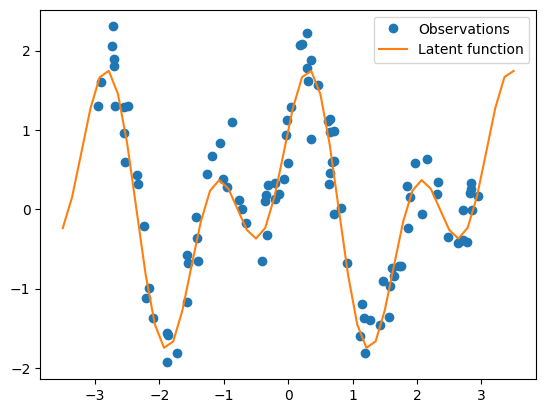

In [30]:
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color=cols[0])
ax.plot(xtest, ytest, label="Latent function", color=cols[1])
ax.legend(loc="best")

In [31]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

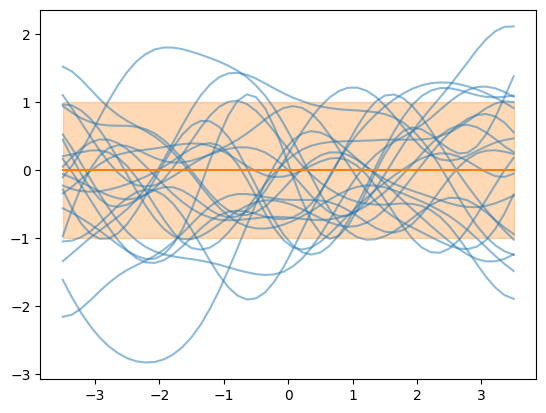

In [32]:
prior_dist = prior.predict(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.stddev()
samples = prior_dist.sample(seed=key, sample_shape=(20,))


fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(xtest, prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
#ax.legend(loc="best")

Note with 500 datapoints I got nans everywhere!  
Some care will be needed to get exactly what I want!

# Next up: Constructing the posterior
(and beyond!)